#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

In [2]:
from scipy.stats import entropy

#### Load weights

In [3]:
def load_dict(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    data = {key: data[key] for key in data.files}
    return data['arr_0'].ravel()[0]

In [4]:
weights_init_conventional = load_dict('wave_recon_weights_init_conventional.npz')
weights_init_rectified = load_dict('wave_recon_weights_init_rectified.npz')
weights_init_dales = load_dict('wave_recon_weights_init_dales.npz')

In [5]:
weights_final_conventional = load_dict('wave_recon_weights_final_conventional.npz')
weights_final_rectified = load_dict('wave_recon_weights_final_rectified.npz')
weights_final_dales = load_dict('wave_recon_weights_final_dales.npz')

#### Load losses, accuracies

In [6]:
test_losses_conventional = np.load('wave_recon_test_losses_conventional_backprop.npy')
test_losses_rectified = np.load('wave_recon_test_losses_rectified_backprop.npy')
test_losses_dales = np.load('wave_recon_test_losses_dales_backprop.npy')

#### Hyper-params

In [14]:
n_epochs = 25
nRuns = 5
N = 128

In [15]:
bins = 100

#### Plot losses and accuracies

In [16]:
def plot_shaded(npy, col, label, marker=None, x = np.arange(n_epochs), deviation='std'):
    mean = np.mean(npy,0)
    if deviation == 'var':
        dev = np.var(npy,0)
    elif deviation == 'std':
        dev = np.std(npy,0)
        
    sns.lineplot(x=x, y=mean, color=col, label=label, marker=marker)
    plt.fill_between(x, np.clip(mean - dev,0,None), mean + dev,color=col, alpha=0.2)
    plt.legend()

Text(0.5, 1.0, 'Wave reconstruction')

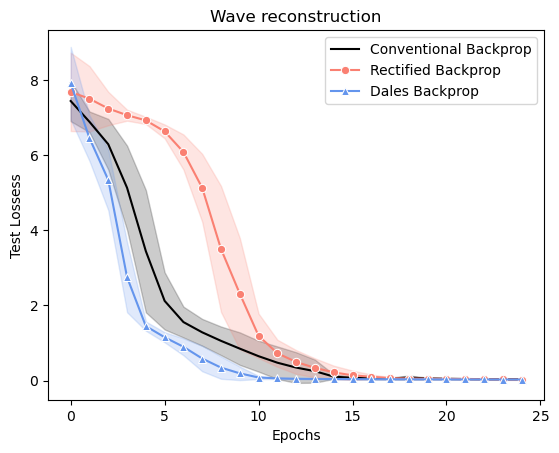

In [34]:
fwave = plt.figure()
plot_shaded(test_losses_conventional,'k', 'Conventional Backprop')
plot_shaded(test_losses_rectified,'salmon', 'Rectified Backprop', 'o')
plot_shaded(test_losses_dales,'cornflowerblue', 'Dales Backprop', '^')
plt.xlabel('Epochs')
plt.ylabel('Test Lossess')
plt.title('Wave reconstruction')

In [36]:
fwave.savefig('wave-recon-test-losses-backprop.svg',dpi=250)

#### Collect weights into single arrays

In [18]:
all_weights_init_conventional = np.concatenate([weights_init_conventional[key].ravel()
                                                for key in sorted(weights_init_conventional.keys())])
all_weights_init_rectified = np.concatenate([weights_init_rectified[key].ravel()
                                                for key in sorted(weights_init_rectified.keys())])
all_weights_init_dales = np.concatenate([weights_init_dales[key].ravel()
                                                for key in sorted(weights_init_dales.keys())])

In [19]:
all_weights_final_conventional = np.concatenate([weights_final_conventional[key].ravel()
                                                 for key in sorted(weights_final_conventional.keys())])
all_weights_final_rectified = np.concatenate([weights_final_rectified[key].ravel()
                                              for key in sorted(weights_final_rectified.keys())])
all_weights_final_dales = np.concatenate([weights_final_dales[key].ravel()
                                          for key in sorted(weights_final_dales.keys())])

In [49]:
def plot_weights_kde(all_weights, col, label, linestyle=None, fill=False):        
    sns.kdeplot(data=all_weights, color=col, label=label, linestyle=linestyle, fill=fill)
    plt.legend()

Text(0.5, 1.0, 'Wave recon: Final Weights')

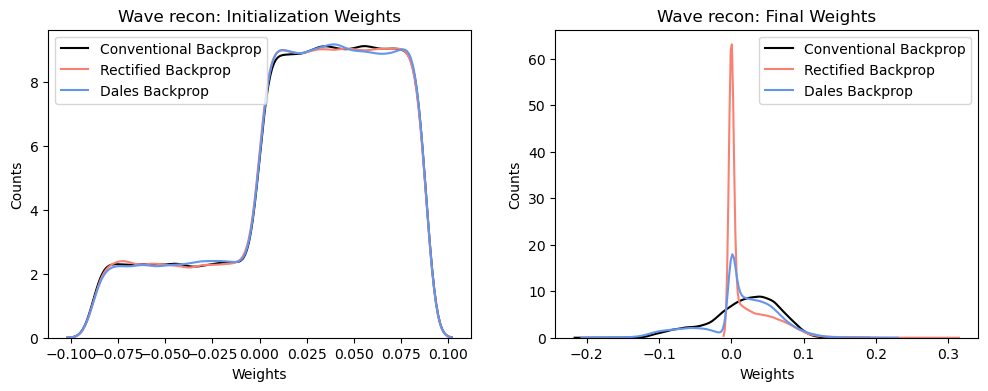

In [51]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_weights_kde(all_weights_init_conventional,'k', 'Conventional Backprop')
plot_weights_kde(all_weights_init_rectified,'salmon', 'Rectified Backprop')
plot_weights_kde(all_weights_init_dales,'cornflowerblue', 'Dales Backprop')
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.title('Wave recon: Initialization Weights')

plt.subplot(122)
plot_weights_kde(all_weights_final_conventional,'k', 'Conventional Backprop')
plot_weights_kde(all_weights_final_rectified,'salmon', 'Rectified Backprop')
plot_weights_kde(all_weights_final_dales,'cornflowerblue', 'Dales Backprop')
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.title('Wave recon: Final Weights')

Text(0.5, 1.0, 'Wave recon: Final Weights')

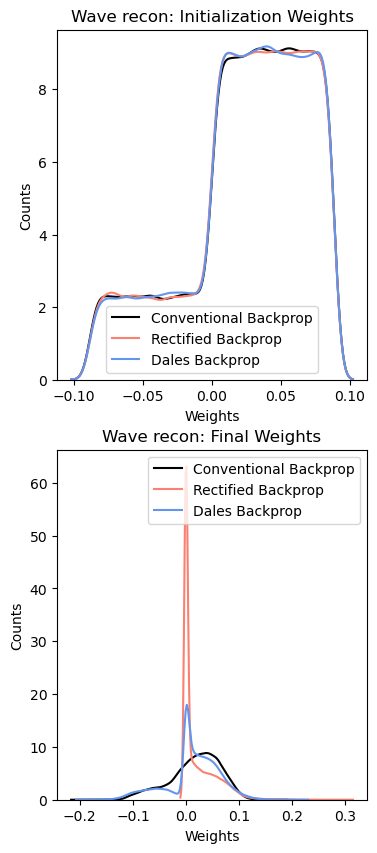

In [57]:
plt.figure(figsize=(4, 10))

plt.subplot(211)
plot_weights_kde(all_weights_init_conventional,'k', 'Conventional Backprop')
plot_weights_kde(all_weights_init_rectified,'salmon', 'Rectified Backprop')
plot_weights_kde(all_weights_init_dales,'cornflowerblue', 'Dales Backprop')
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.title('Wave recon: Initialization Weights')

plt.subplot(212)
plot_weights_kde(all_weights_final_conventional,'k', 'Conventional Backprop')
plot_weights_kde(all_weights_final_rectified,'salmon', 'Rectified Backprop')
plot_weights_kde(all_weights_final_dales,'cornflowerblue', 'Dales Backprop')
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.title('Wave recon: Final Weights')

Text(0.5, 1.0, 'Wave recon')

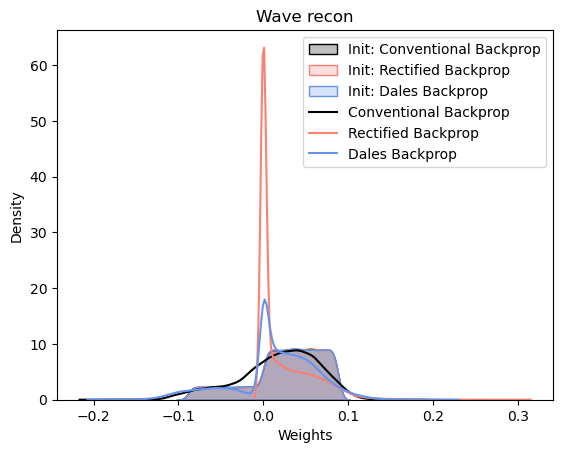

In [55]:
plt.figure()


plot_weights_kde(all_weights_init_conventional,'k', 'Init: Conventional Backprop','-',fill=True)
plot_weights_kde(all_weights_init_rectified,'salmon', 'Init: Rectified Backprop','-',fill=True)
plot_weights_kde(all_weights_init_dales,'cornflowerblue', 'Init: Dales Backprop','-',fill=True)


plot_weights_kde(all_weights_final_conventional,'k', 'Conventional Backprop')
plot_weights_kde(all_weights_final_rectified,'salmon', 'Rectified Backprop')
plot_weights_kde(all_weights_final_dales,'cornflowerblue', 'Dales Backprop')

plt.xlabel('Weights')
# plt.ylabel('Counts')
plt.title('Wave recon')

#### Quantify distances between histograms

In [22]:
def kl_div_weights(wdict1, wdict2):
    kl_divs = np.zeros((nRuns, nRuns))
    for ii in tqdm(range(nRuns)):
        for jj in range(nRuns):
            hist1, _ = np.histogram(wdict1[ii], bins=100, density=True)
            hist1 += 1e-7
            hist2, _ = np.histogram(wdict2[jj], bins=100, density=True)
            hist2 += 1e-7
            kl_divs[ii,jj] = entropy(hist1, hist2)
    return kl_divs

In [23]:
kl_init_rectified = kl_div_weights(weights_init_conventional,weights_init_rectified)
kl_init_dales = kl_div_weights(weights_init_conventional,weights_init_dales)
kl_init_conventional = kl_div_weights(weights_init_conventional,weights_init_conventional)

100%|██████████| 5/5 [00:00<00:00, 253.09it/s]


In [24]:
kl_final_rectified = kl_div_weights(weights_final_conventional,weights_final_rectified)
kl_final_dales = kl_div_weights(weights_final_conventional,weights_final_dales)
kl_final_conventional = kl_div_weights(weights_final_conventional,weights_final_conventional)

100%|██████████| 5/5 [00:00<00:00, 297.77it/s]


In [25]:
def kl_div_stats(kl_data, kl_control, deviation='var'):
     
    mean_data = np.mean(kl_data)
    mean_control = np.mean(kl_control)
    
    if deviation == 'std':
        dev_data = np.std(kl_data)
        dev_control = np.std(kl_control)
    elif deviation == 'var':
        dev_data = np.var(kl_data)
        dev_control = np.var(kl_control)
        
    mean = mean_data #- mean_control
    dev = dev_data
    
    return mean, dev

In [26]:
kl_mean_init_rectified, kl_dev_init_rectified = kl_div_stats(kl_init_rectified, kl_init_conventional)
kl_mean_init_dales, kl_dev_init_dales = kl_div_stats(kl_init_dales, kl_init_conventional)

In [27]:
kl_mean_final_rectified, kl_dev_final_rectified = kl_div_stats(kl_final_rectified, kl_final_conventional)
kl_mean_final_dales, kl_dev_final_dales = kl_div_stats(kl_final_dales, kl_final_conventional)

In [41]:
kl_dev_final_dales

0.020620606279076102

In [28]:
categories = ['Initialization', 'Final']
group_labels = ['Rectified Backprop', 'Dales Backprop']
scale = 1

means1 = [kl_mean_init_rectified*scale, kl_mean_final_rectified]  # Mean values for group 1
devs1 = [kl_dev_init_rectified*scale, kl_dev_final_rectified]    # Standard deviations or variances for group 1

means2 = [kl_mean_init_dales*scale, kl_mean_final_dales]  # Mean values for group 2
devs2 = [kl_dev_init_dales*scale, kl_dev_final_dales]  # Standard deviations or variances for group 2

# Calculate error bars (95% confidence interval assuming normal distribution)
error1 = [0.5 * d for d in devs1]
error2 = [0.5 * d for d in devs2]

bar_width = 0.2

In [29]:
# # Set the positions of the bars on the x-axis
# r1 = np.arange(len(categories))
# r2 = [x + bar_width for x in r1]

# # Plot grouped bar plot
# plt.figure(figsize=(8, 4))
# plt.bar(r1, means1, yerr=error1, capsize=2, width=bar_width, label='Rectified Backprop', color='salmon')
# plt.bar(r2, means2, yerr=error2, capsize=2, width=bar_width, label='Dales Backprop', color='cornflowerblue')

# # Add xticks on the middle of the group bars
# plt.xlabel('Weight Distributions', fontweight='bold')
# plt.xticks([r + bar_width/2 for r in range(len(categories))], categories)

# # Add labels and title
# plt.ylabel('KL Divergences')
# plt.title('Changes in Weight Distributions', fontweight='bold')

# # Add legend
# plt.legend()

# # Show plot
# plt.show()

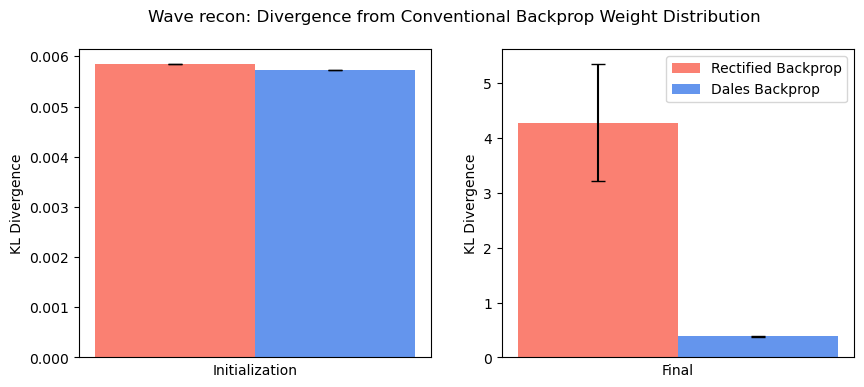

In [30]:
plt.figure(figsize=(10,4))

plt.subplot(121)
# Set the positions of the bars on the x-axis
r1 = np.arange(len(categories[0]))
r2 = [x + bar_width for x in r1]

# Plot grouped bar plot
plt.bar(r1[0], means1[0], yerr=error1[0], capsize=5, width=bar_width, label='Rectified Backprop', color='salmon')
plt.bar(r2[0], means2[0], yerr=error2[0], capsize=5, width=bar_width, label='Dales Backprop', color='cornflowerblue')

plt.xticks([])
plt.xlabel('Types')

# Add labels and title
plt.ylabel('KL Divergence')
plt.xlabel(categories[0])

plt.subplot(122)
# Set the positions of the bars on the x-axis
r1 = np.arange(len(categories[1]))
r2 = [x + bar_width for x in r1]

# Plot grouped bar plot
plt.bar(r1[1], means1[1], yerr=error1[1], capsize=5, width=bar_width, label='Rectified Backprop', color='salmon')
plt.bar(r2[1], means2[1], yerr=error2[1], capsize=5, width=bar_width, label='Dales Backprop', color='cornflowerblue')

plt.xticks([])

# Add labels and title
plt.ylabel('KL Divergence')
plt.xlabel(categories[1])

# Show plot
plt.legend()
plt.suptitle('Wave recon: Divergence from Conventional Backprop Weight Distribution')
plt.show()